# Important - do this first!

**Double click here and enter the student numbers for all group members. Do not enter any names.**

1.
2.
3.
4.

Now **[click on this link and read the MATH0011 project instructions.](https://www.ucl.ac.uk/~ucahmto/0011/project-instructions.html)**



In this project you will implement your own version of one of the most fundamental optimization algorithms, [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), test it out on some example functions, and create a visualisation of the result.  After that you'll use one of the optimizers built in to the [`scipy`](https://scipy.org/) module to implement a commonly-used machine learning model called the support vector machine, and again visualise the results on some simulated data.

The project is a good fit for people interested in artificial intelligence/machine learning. There is some flexibility in how to store the data you are generating and working with, so you will also gain experience of choosing appropriate representations (and probably learn why certain bad choices are not so good).  Don't be afraid to go back and change the code you have already written if you begin to regret the decisions you made earlier.  There is quite a bit of code to write, but you will certainly learn some useful things.



# Part 1 - gradient descent and ascent

Gradient ascent and descent are algorithms for finding [local minimums and maximums](https://www.mathsisfun.com/algebra/functions-maxima-minima.html) of a differentiable function of several variables.  In this part you will implement a simple version of gradient descent for functions $F : \mathbb{R}^2 \to \mathbb{R}$ and learn how to create plots that demonstrate the behaviour of the algorithm using `matplotlib` and NumPy.

First we need some definitions. The **gradient** of a function $F : \mathbb{R}^2 \to \mathbb{R}$, written $\nabla F$, is the function $\nabla F : \mathbb{R}^2 \to \mathbb{R}^2$ given by 

$$ \nabla F (\mathbf{v}) = \begin{pmatrix} \frac{\partial F}{\partial x} (\mathbf{v}) \\ \frac{\partial F}{\partial y}(\mathbf{v})\end{pmatrix} $$

where $\frac{\partial F}{\partial x} (\mathbf{v})$ is the [partial derivative](https://en.wikipedia.org/wiki/Partial_derivative) defined by

$$ \frac{\partial F}{\partial x} (v_1, v_2) = \lim_{h\to 0} \frac{F(v_1+h, v_2) - F(v_1, v_2)}{h} $$ 

and $\frac{\partial F}{\partial y}$ is defined similarly.

For example, if $F(x, y) = xy + x^2 + 2y + 3$ then 

$$\frac{\partial F}{\partial x} (x, y) = y + 2x \;\;\;\; \frac{\partial F}{\partial y}(x,y) = x + 2$$

so $\nabla F (x, y) = \begin{pmatrix} y+2x \\ x+2 \end{pmatrix}$.

The significance of the gradient is that at a point $\mathbf{v} \in \mathbb{R}^2$, the direction in which $F$ increases fastest is $\nabla F( \mathbf{v})$ and the direction in which $F$ decreases fastest is $-\nabla F(\mathbf{v})$.  You'll learn more about this after reading week in MATH0011.

The gradient gives us a simple way of looking for a local maximum of a function $F: \mathbb{R}^2 \to \mathbb{R}$. Pick some point $\mathbf{a}_0$ to start off at, then move a small distance in the direction of $\nabla F( \mathbf{a}_0)$, taking you to a new point $\mathbf{a}_1$ with a bigger value of $F$, then move a small distance in the direction of $\nabla F(\mathbf{a}_1)$ to a new point $\mathbf{a}_2$, and so on.  This is gradient ascent.  (To see how the method works, imagine you are standing somewhere on a foggy mountain and want to climb to the top.  If you keep walking in the steepest uphill direction you can find, you may eventually get to the top, as long as there is only one peak).  To find a local minimum value of $F$ we can do the same thing except we move in the direction $- \nabla F$, since this is the direction in which $F$ decreases fastest - this is gradient *de*scent.

**Write a function `approx_grad(f, v, h)` which returns an approximation to the gradient of the function `f` at the point `v` using a change in x and y of `h`.**

`f` will be a function of two variables and `v` will be a list `[a, b]` or a NumPy array giving the coordinates of the point at which you will approximate the gradient of `f`.

**Your function must return a tuple of length 2** (or a NumPy array, if it makes your code easier to use) whose first element is

$$\frac{f(a+h, b) - f(a, b)}{h} $$

which is an approximation of $\frac{\partial f}{\partial x}(a, b)$, and whose second element is

$$\frac{f(a, b+h) - f(a, b)}{h} $$

which is an approximation of $\frac{\partial f}{\partial y}(a, b)$.



In [9]:
def approx_grad(f: callable, v: tuple[float, float], h: float) -> tuple[float, float]:
    """
    Approximates gradient of a given function at point (a, b) using numerical differentiation.

    Parameters:
    - f: function of two variables whose gradient we want to approximate.
    - v: point (a, b) on the function at which we want to approximate the gradient.
    - h: change in x and y used in the approximation.
    
    Returns: approximate gradient (partial x, partial y).
    """
    a, b = v
    partial_x = (f(a + h, b) - f(a, b)) / h
    partial_y = (f(a, b + h) - f(a, b)) / h
    return (partial_x, partial_y)

**Check your approximation** for the function $F(x, y) = xy + x^2 + 2y + 3$ by comparing it to the partial derivatives given above.  Try values of `x` and `y` between `-3` and `3` and experiment to see how `h` affects how close the approximation is to the true value.

In [10]:
def f(x, y):
    return x * y + x * x + 2 * y + 3

point = (-3, 2)
delta = 0.000001

approximation = approx_grad(f, point, delta)

x, y = point
true_gradient = (y + 2 * x, x + 2)

print(f"Approximate gradient at point {point}: {approximation}")
print(f"True gradient at point {point}: {true_gradient}")

Approximate gradient at point (-3, 2): (-3.9999990004702113, -1.0000000010279564)
True gradient at point (-3, 2): (-4, -1)


The gradient descent algorithm for a function $f : \mathbb{R}^2 \to \mathbb{R}$ that you are going to implement begins with a point $\mathbf{a}_0 \in \mathbb{R}^2$ and produces a sequence defined by

$$ \mathbf{a}_{i+1} \approx \mathbf{a}_i - k \nabla f (\mathbf{a}_i) $$

where $k$ is a fixed small positive number called the *step size*. The reason I have written $\approx$ and not $=$ is that you are going to use your `approx_grad` function to obtain an approximation to $\nabla f(\mathbf{a}_i)$ in place of the actual gradient.

**Write a function `gradient_descent_sequence(f, a0, k, h, N)`** which behaves as follows.

 - `f` is a function of two variables
 - `a0` is a list of length 2 containing the x and y coordinates of the starting point of the gradient descent algorithm
 - `k` is the step size, as above
 - `h` is the change in x and y used to calculate an approximation to the gradient, which you will pass to your function from part 1
 - `N` specifies the number of terms of the gradient descent sequence after `a0` to be calculated
 
**The output of your function should be a tuple of two lists of numbers**, the first list being the x-coordinates of the sequence $\mathbf{a}_0, \mathbf{a}_1, \ldots, \mathbf{a}_{N}$ and the second list being the y-coordinates.  Again, you can use arrays instead of tuples and lists if you prefer.

In [11]:
def gradient_descent_sequence(f: callable, a0: tuple[float, float], k: float, h: float, N: int) -> tuple[list[float], list[float]]:
    """
    Performs gradient descent optimisation on a given function.

    Parameters:
    - f: function we want to minimise.
    - a0: starting point (a, b) on the function.
    - k: step size for descent (small and positive).
    - h: change in x and y (small and positive).
    - N: number of iterations.
    
    Returns:
    Tuple of two lists: 
    1. x-coordinates of the gradient descent sequence.
    2. y-coordinates of the gradient descent sequence.
    """
    x_coords = [a0[0]]
    y_coords = [a0[1]]

    for _ in range(N):
        grad = approx_grad(f, (x_coords[-1], y_coords[-1]), h)
        x_coords.append(x_coords[-1] - k * grad[0])
        y_coords.append(y_coords[-1] - k * grad[1])

    return x_coords, y_coords

# Part 2 - plotting the gradient descent sequences

**Calculate the gradient descent sequence** for the function $g(x, y) = x^2 + 2y^2$ starting at $(1, -1)$ with `N = 10`, `k = 0.2`, `h = 0.1`, then **plot the points in the gradient descent sequence** using the `matplotlib.pyplot` function `plot` .  The function has its minimum at $(0, 0)$, so you should see the line tending towards the origin.

To make your plot look better, you may want to experiment with the `linewidth` parameter to the `plot` command

```python
plt.plot(xs, ys, 'r-', linewidth=0.5)
```

and to use `plt.xlim()` and `plt.ylim()` to control the range of x-coordinates and y-coordinates which are plotted. [This link](https://stackabuse.com/how-to-set-axis-range-xlim-ylim-in-matplotlib/) has some examples on the use of `xlim` and `ylim`.



Matplotlib is building the font cache; this may take a moment.


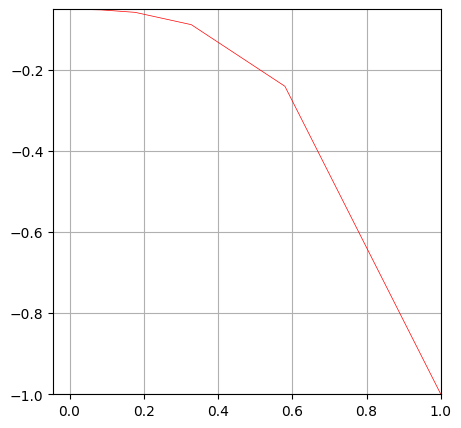

In [12]:
# plotting code goes here
import matplotlib.pyplot as plt
import numpy as np

def g(x, y):
    return x**2 + 2*y**2

x_coords, y_coords = gradient_descent_sequence(g, [1, -1], 0.2, 0.1, 10)

plt.figure(figsize=(5,5))
plt.plot(x_coords, y_coords, 'r-', linewidth=0.5)
plt.xlim([min(x_coords), max(x_coords)])
plt.ylim([min(y_coords), max(y_coords)])
plt.grid()
plt.show()

The plot above isn't very satisfying.  It would be better if you could see both the points of the gradient descent sequence and a visual representation of the function whose minimum you are looking for on the same axes, so that you can see what the gradient ascent/descent algorithm is doing.   Since you are working with functions $f : \mathbb{R}^2 \to \mathbb{R}$ you need to indicate the value of $f$ at the point $(x, y)$ in some way.  In this part you will use `matplotlib`'s functions `contour` and `contourf` to make a plot that uses colours and contours to indicate the value of a function $f$ at the point $(x, y) \in \mathbb{R}^2$.

Start by reading [the Wikipedia article on contour lines](https://en.wikipedia.org/wiki/Contour_line) until you understand what a contour plot is.

The `contour` function from `matplotlib.pyplot` is used in a similar way to the `plot` command, except that you must supply lists or numpy arrays of the x-coordinates, y-coordinates, and z-coordinates for your plot.  Luckily NumPy has functions which make this a lot easier.  We will keep things by simple by choosing x-coordinates and y-coordinates on a rectangular grid - for example, if the x-values are 1, 2, 3 and the y-values are 4, 5, 6 then the grid points would be at (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6).

First, produce arrays of the x-values and y-values using `np.linspace`:

```python
x_grid_values = np.linspace(-5, 5, 100)
y_grid_values = np.linspace(-5, 5, 100)
```

The numpy function `meshgrid` will assemble these into arrays containing all of the x- and y-coordinates we need for the plot.

```python
xs, ys = np.meshgrid(x_grid_values, y_grid_values)
```

Next, get the z-value for each of the gridpoints.  You could do this using some for loops, but again there is a numpy function to make it easy: if `g(x, y)` is a two-variable function which we want to apply to every one of our grid points, then `np.vectorize(g)` is a new function which can be applied to `xs` and `ys` to give the array of z-coordinates we need.

```python
zs = np.vectorize(g)(xs, ys)
```

Having prepared the x-, y-, and z-coordinates you can now just call `plt.contour(xs, ys, zs)` or `plt.contourf(xs, ys, zs)` to produce our contour plots.  You can experiment with `plt.contour(xs, ys, zs, levels=N)` where `N` is an integer to control how many contours are plotted.  Other ways to get the plot looking good are:

 - try `plt.axis('scaled')` to adjust scaling of the axes
 - calling `plt.colorbar()` shows how values of the function correspond to colours in the plot
 - read about colourmaps [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html) and then try `plt.contour(xs, ys, zs, levels=N, cmap=plt.get_cmap('turbo'))` for example.
 

**Following the instructions above, produce a `contour` or `contourf` plot of the function `g` defined below using values of `x` and `y` between -5 and 5.**  Include a colourbar in your plot, and experiment with parameter values to get the plot looking as good as possible.



In [13]:
def g(x, y):
    return ((x**2 + y -11)**2 + (x+y**2 - 6)**2)

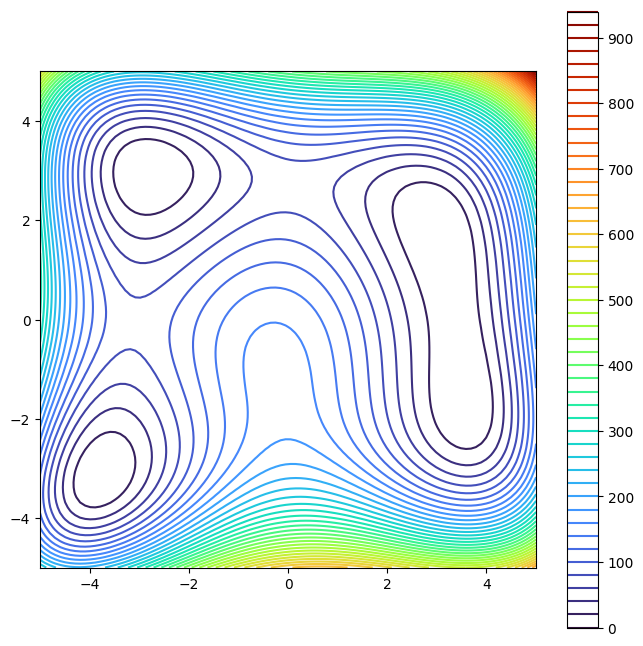

In [14]:
# make the contour plot of g here

x_grid_values = np.linspace(-5, 5, 100)
y_grid_values = np.linspace(-5, 5, 100)

xs, ys = np.meshgrid(x_grid_values, y_grid_values) # create a grid of x and y coordinates
zs = np.vectorize(g)(xs, ys) # vectorise the function g and apply it to the grid to get the z values

plt.figure(figsize=(8,8))
plt.contour(xs, ys, zs, levels=50, cmap=plt.get_cmap('turbo'))
plt.axis('scaled')
plt.colorbar()
plt.show()

Finally, **use `contourf` to plot the function `g` above** and on the same plot, **use `plot` to show the points generated by `gradientDescentSequence` starting at (0, -3)**, adjusting `h`, `k`, and `N` so that they converge to one of the local minimums.  Indicate the starting point (0, -3) on the plot somehow and choose plotting colours and a colour map so that it is easy to see what is happening in the plot.

You should see the gradient descent sequence going into one of the dark coloured holes on the plot (if you use the `turbo` colour map).

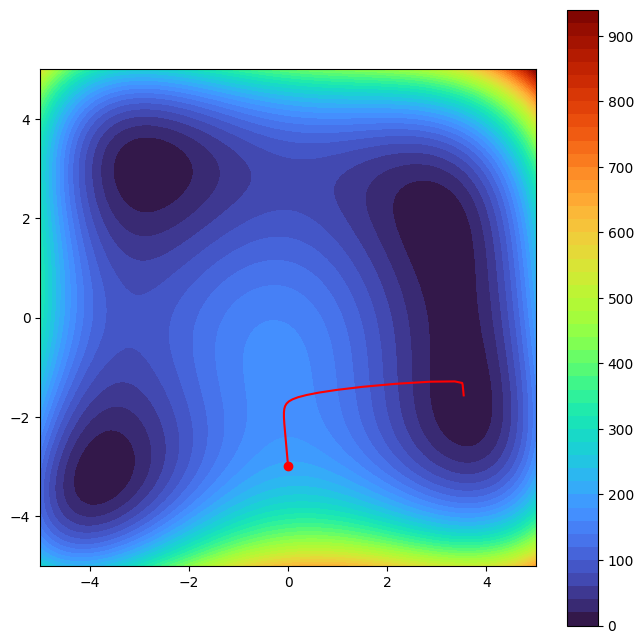

In [15]:
# contour plot and gradient descent sequence here

start_point = (0, -3)
step_size = 0.01
delta = 0.01
iterations = 1000
x_coords, y_coords = gradient_descent_sequence(g, start_point, step_size, delta, iterations)

plt.figure(figsize=(8,8))
plt.contourf(xs, ys, zs, levels=50, cmap=plt.get_cmap('turbo'))
plt.axis('scaled')
plt.colorbar()
plt.scatter(*start_point, color='red', marker='o')
plt.plot(x_coords, y_coords, 'r-', linewidth=1.5)
plt.show()

# Part 3 - support vector machines

The [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) is a commonly-used machine learning model which uses an optimizer like the gradient descent algorithm you just implemented to help classify data.

Suppose you have a collection of elements of $\mathbb{R}^k$ called *data points*, each of which has a known *type* which is either 1 or -1.  This is called the *training data*.  You want to use these points to generate a *classifier* which, given a new data point, will tell you whether it is most likely to be of type 1 or of type -1.    For example, perhaps the points are derived from images of cats (type 1) and dogs (type -1), and you want to decide whether a new image is of a cat or of a dog.

The simplest kind of SVM finds a *hyperplane* (a line in 2D space, a plane in 3D space, and so on) such that, as far as possible, all the type 1 training points are on one side of the hyperplane and all the type -1 training points are on the other side.  Given a new data point we then predict its type by simply checking which side of the hyperplane it lies on.

Of course, in general it will not be possible to find any hyperplane that has all the type 1 points on one side and all the type -1 points on the other.  In that case the method finds the "best" hyperplane in a sense made precise by the loss function defined later.

**Write a function `generate_random_data(x0, y0, spread, n)` which generates `n` random two-dimensional data points centred at the point $(x_0, y_0)$.** The input `spread` to your function should control how widely spread out the points are around $(x_0, y_0)$: when `spread` is a small number, all data points should be close to $(x_0, y_0)$, and when `spread` is a large number, points should be more spread out.

For the randomisation, you could use the `random` module or [`np.random.rand`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) or similar Numpy functions.

It's up to you how these points are represented: choose whatever you think will be convenient later. You could store each point as a tuple `(x, y)` and return a list of `n` tuples, for example.  Alternatively you could return a list of lists `[x, y]`, or one-dimensional numpy arrays `np.array([x, y])`, or numpy column vectors `np.array([[x], [y]])`, or numpy row vectors `np.array([[x, y]])`, or you could return one big two-dimensional numpy array whose rows (or columns) are the data points.

When you've done this, make two plots using `matplotlib.pyplot`. The first plot should show 20 random points generated with your `generate_random_data` function centred at (0, 1) as red dots, and 20 random points centred at (1, 0) as blue dots, with the `spread` parameter chosen so that the dots are tightly clustered.  The second plot should be the same as the first except with the `spread` parameter made larger so that there is some overlap between the two sets of dots.

The first plot should look roughly like this:

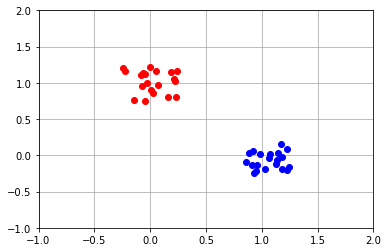

and the second should look roughly like this:

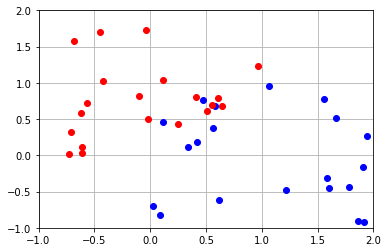

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# def generate_random_data(x0, y0, spread, n):
def generate_random_data(x0: float, y0: float, spread: float, n: int) -> np.array:
    """
    Generates a cluster of random data points around a given center.

    Parameters:
    - x0: x-coordinate of the center.
    - y0: y-coordinate of the center.
    - spread: spread factor around the center.
    - n: number of data points to generate.

    Returns:
    Tuple of two lists:
    1. List of x-coordinates of the generated data points.
    2. List of y-coordinates of the generated data points.
    """
    x_vals = []
    y_vals = []
        
    rand_vals = np.random.rand(2, n)
    
    for j in range(n):
        x_vals.append(x0 + 2*spread*rand_vals[0,j] - spread)
        y_vals.append(y0 + 2*spread*rand_vals[1,j] - spread)
    
    return [x_vals, y_vals]
    

In [17]:
def plot_cluster_graph(red_points: np.array, blue_points: np.array, xy_lim: tuple[float, float]) -> None:
    '''
    Plots a graph with two distinct clusters given the specified parameters.
    
    Parameters:
    - red_points: numpy array of coordinates of the red points.
    - blue_points: numpy array of coordinates of the blue points.
    - xy_lim: range of values for both the x-axis and y-axis in the plot.
    '''
    plt.figure(figsize=(5,5))
    plt.xlim(xy_lim)
    plt.ylim(xy_lim)
    plt.plot(red_points[0], red_points[1], 'ro')
    plt.plot(blue_points[0], blue_points[1], 'bo')
    plt.grid()

In [18]:
# this cell contains parameters to be used in the following test plots
default_xy_lim = (-1.0, 2.0)
small_spread = 0.2
large_spread = 1.0
red_centre = (0, 1)
blue_centre = (1, 0)
n = 20


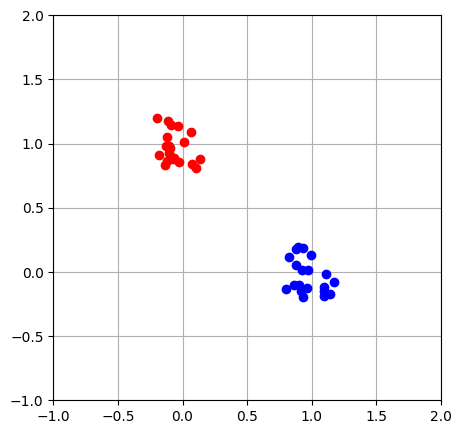

In [19]:
# use this cell for your first plot, where the spread should be small
red_points = generate_random_data(*red_centre, small_spread, n)
blue_points = generate_random_data(*blue_centre, small_spread, n)

plot_cluster_graph(red_points, blue_points, default_xy_lim)
plt.show()

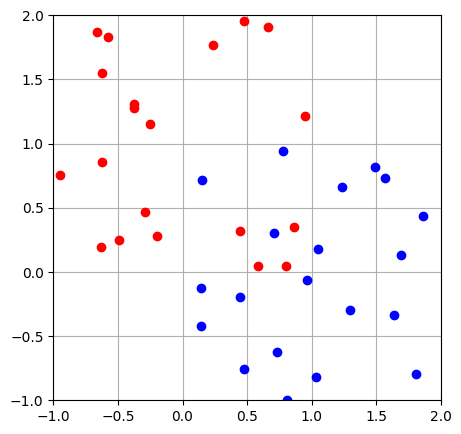

In [20]:
# use this cell for your second plot, where the spread is larger
red_points = generate_random_data(*red_centre, large_spread, n)
blue_points = generate_random_data(*blue_centre, large_spread, n)

plot_cluster_graph(red_points, blue_points, default_xy_lim)
plt.show()

# Part 4 - the SVM loss function

Suppose we have *training data* consisting of $n$ vectors $\mathbf{x}_1, \ldots, \mathbf{x}_n \in \mathbb{R}^k$ and that each $\mathbf{x}_i$ has a *type* $y_i$ which is either 1 or -1.  In the following diagram I've coloured the type 1 points red and the type -1 points blue.

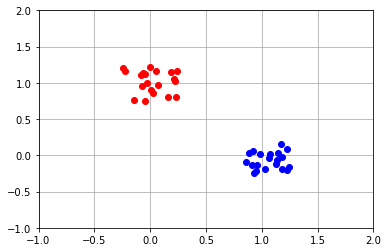

We call this data *linearly separable* if there exists a hyperplane such that all the type 1 points are on one side of the hyperplane and all the type -1 points are on the other side.  In the two-dimensional example above, the data is linearly separable: there are many possible straight lines which separate the red and blue dots.

When the data is linearly separable we can choose a hyperplane with all the type 1 points above it and all the type -1 points below it. This hyperplane can be used as a classifier: if a new point is on the same side as the type 1 points we will classify the new point as type 1, and if it is on the other side we will classify it as having type -1.

Mathematically, the classifier works like this.  Any hyperplane in $\mathbb{R}^k$ can be written as the set of all points $\mathbf{x}$ such that $\mathbf{w}^T \mathbf{x} = b$, for some vector $\mathbf{w}$ and some scalar $b$.  The hyperplane divides $\mathbb{R}^k$ into two pieces: points $\mathbf{u}$ for which $\mathbf{w}^T \mathbf{u} > b$ (above the hyperplane) and points for which $\mathbf{w}^T\mathbf{u}  < b$ (below the hyperplane). Assume that the type 1 points $\mathbf{x}_i$ satisfy $\mathbf{w}^T \mathbf{x}_i >b$. In that case, the classifier says that a new point $\mathbf{u}$ has type 1 if $\mathbf{w}^T \mathbf{u} > b$, and that it has type -1 otherwise.

As you can see from the diagram above, when data is linearly separable there may be many different hyperplanes which separate the two types of datapoint. The choice of hyperplane affects how the classifier performs, so we must choose it carefully.  One possibility is to use the separating hyperplane with the widest *margin*.  Consider the hyperplane $\mathbf{w}^T \mathbf{x} = b$.  There is another, parallel hyperplane $\mathbf{w}^T \mathbf{x} = b+1$ above it and another, parallel hyperplane $\mathbf{w}^T \mathbf{x} = b-1$ below it.  The area between these is called the margin, and we can then look for the hyperplane that maximises the width of the margin subject to all of the positive and negative datapoints being outside it.

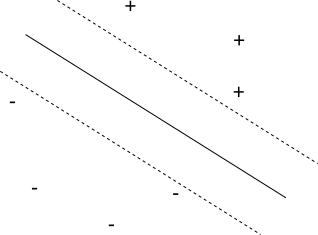

The image above shows type 1 data points as + signs and type -1 data points as - signs.  The solid line in the centre is a hyperplane $\mathbf{w}^T \mathbf{x} = b$, and the parallel dotted lines either side of it are the boundaries of the margin, whose equations are $\mathbf{w}^T \mathbf{x} = b \pm 1$. The area between the two dotted lines is the margin and its width is the distance from one dotted line to the other.

For a vector $\mathbf{u} = \begin{pmatrix} u_1 \\ \vdots \\ u_k \end{pmatrix}$ we define $||\mathbf{u}||$, the length of $\mathbf{u}$, to be $\sqrt{\sum_{i=1}^k u_i^2}$.  It turns out that the width of the margin is equal to $2/||\mathbf{w}||$, so maximising the width of the margin is equivalent to minimising $||\mathbf{w}||$ subject to the constraint that all type 1 data points $\mathbf{x}_+$ satisfy $\mathbf{w}^T \mathbf{x}_+ \geqslant b+1$ (that is, they are above the margin) and all type -1 datapoints $\mathbf{x}_-$ satisfy $\mathbf{w}^T \mathbf{x}_- \leqslant b - 1$ (that is, they are below the margin).

In general the data we work with may not be linearly separable. Consider the example below where as before, type 1 datapoints are red and type -1 datapoints are blue.

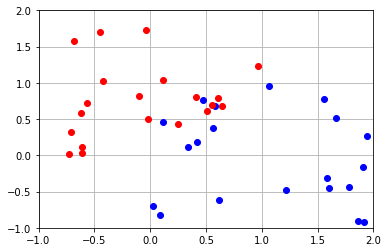

There is no straight line which separates the red and blue dots.  To help us make a classifier, recall that a vector $\mathbf{u}$ lies above the margin if $\mathbf{w}^T \mathbf{u} \geqslant b + 1$ and below it if $\mathbf{w}^T \mathbf{u} \leqslant b - 1$.  A type 1 point $\mathbf{x}_i$ is above the margin if $\mathbf{w}^T\mathbf{x}_i \geqslant b+1$, that is, $\mathbf{w}^T\mathbf{x}_i - b \geqslant 1$ and a type -1 point $\mathbf{x}_i$ is below the margin if $\mathbf{w}^T \mathbf{x}_i \leqslant b - 1$, that is $\mathbf{w}^T\mathbf{x}_i -b\geqslant 1$.  Letting $y_i=1$ if $\mathbf{x}_i$ is type 1 and $y_i=-1$ if $\mathbf{x}_i$ is type -1, we can summarise this by saying all data points $\mathbf{x}_i$ are on the correct side of the margin if and only if all of the inequalities

$$ y_i(\mathbf{w}^T \mathbf{x}_i -b) \geq 1$$

are true, or equivalently, if $1-y_i(\mathbf{w}^T \mathbf{x}_i - b) \leq 0$ for all $i$. Thus the sum

$$ \sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)) $$

is a nonnegative quantity that is zero if all data points are on the correct sides of the margins $\mathbf{w}^T \mathbf{x}  =b \pm 1$ and which gets bigger as points get further away from the correct side of the margin.  This is called the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss)

The SVM classifier then needs to make a tradeoff between making $||\mathbf{w}||$ small and making $$ \sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)) $$ small so that points are close to being on the right side of the margins.  It does this by choosing a constant $\lambda$ and minimizing the **loss function**

$$\lambda ||\mathbf{w}||^2 + \frac{1}{n}\sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)).$$

The parameter $\lambda$ determines the tradeoff between margin size and classification error.  If we don't mind having a small margin but hate having points on the wrong side of the margin we make $\lambda$ small; if we absolutely must have a big margin but don't care about a few mis-classified training points we make $\lambda$ big. You can read more details about this loss function and some applications of the SVM on [Andrew Zisserman](https://www.robots.ox.ac.uk/~az/lectures/ml/index.html)'s [lecture slides](https://www.robots.ox.ac.uk/~az/lectures/ml/lect2.pdf).

**Write a function `loss(bw, data)` which computes the loss function above.**  You can set $\lambda = 0.01$ to begin with.  The input `bw` should be a 1-dimensional Numpy array whose first element represents $b$ in the formula above and whose remaining elements are the entries of the vector $\mathbf{w}$.  The input `data` should somehow contain all the vectors $\mathbf{x}_i$ and their types $y_i$, but it's up to you exactly what kind of Python object to use.  However, you can't change the inputs of the `loss` function: it must take these two arguments only (because we're going to use it with the `scipy.optimize.minimize` function later which requires the function to be of this form).

In [21]:
def loss(bw: np.array, data: tuple[np.array, np.array]) -> float:
    '''
    Computes the hinge loss for the SVM given the bias, the weights and the training data.

    Parameters:
    - bw: a numpy array comprising a bias term followed by weights.
    - data: a tuple containing two numpy arrays:
     1. The feature matrix 'X' (an array of datapoints).
     2. The corresponding target values 'y' (a classification as 1 or -1).

    Returns: the calculated total hinge loss.
    '''
    b = bw[0]
    w = bw[1:]

    l = 0.01
    regularisation_term = l * np.sum(w**2)  # λ ||w||^2
    
    X = data[:, :-1]
    y = data[:, -1]

    hinge_losses = []
    for i in range(len(X)):
        hinge_loss = max(0, 1 - y[i] * (np.dot(w, X[i]) - b))
        hinge_losses.append(hinge_loss)

    total_loss = regularisation_term + (1 / len(data)) * sum(hinge_losses)
    return total_loss

# Part 5 - finding and plotting the minimizing hyperplane

To find a choice of $b$ and $\mathbf{w}$ which (approximately) minimizes the loss function defined in the last part you are going to use the [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.  **Read the documentation** by [clicking here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to find out about it.  Your call to `minimize` should only supply the fun, x0, and args parameters: don't change any of the other stuff.

In this part you are going to practise using `minimize` on a simple example function which I have defined in the cell below.  The function `f(bw, data)` expects a one-dimensional numpy array `bw` of shape `(2,)` and a second argument `data`, again a one-dimensional array of shape `(2,)`.  

**Use `scipy.optimize.minimize` to find the minimum value of `f` and the point at which that minimum occurs**.

Of course, the minimum value of `f` is 2 and this is attained at the point specified by `testdata`, so you will be able to see if your `minimize` call has worked correctly.  `minimize` returns a Python object with several instance variables, most of which you can ignore: the important ones are called `fun`, which tells you the minimum value, and `x`, which tells you the point at which the minimum occurred.

In [22]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [23]:
def f(bw, data):
    return 2 + (bw[0] - data[0]) ** 2 + (bw[1] - data[1]) ** 2

testdata = np.array([1, 2])

In [24]:
# use minimize here
initial_guess = np.array([0, 0])

result = minimize(f, initial_guess, args=(testdata,))
min_value = result.fun
min_point = result.x

print("Minimum value:", min_value)
print("Point at which minimum occurs:", min_point)

Minimum value: 2.000000000000001
Point at which minimum occurs: [1.00000002 1.99999998]


Now that you've learned to use `scipy.optimize.minimize`, you're ready to
**write a function `svm_demo(n, redCentre, blueCentre, spread)`** which does the following.

 - calls your `generate_random_data` to generate `n` random data points centred at `redCentre` and `n` random data points centred at `blueCentre` using `spread` to control how spread out they are
 - uses `minimize` to find the hyperplane $\mathbf{w}^T \mathbf{x} = b$ that minimizes the SVM loss function
 - plots the type 1 points (in red), the type -1 points (in blue), the minimizing hyperplane, and the two margin hyperplanes $\mathbf{w}^T \mathbf{x} = b \pm 1$ all on the same axes.  Don't worry if the points aren't all outside the margins.

**Call the function `svm_demo(20, [0, 1], [1, 0], s)` where `s` is just big enough so that the points aren't linearly separable.**

In [25]:
def svm_demo(n: int, redCentre: tuple[float, float], blueCentre: tuple[float, float], spread: float) -> None:
    '''
    Minimises the loss function for the SVM, then plots the resulting hyperplane separating between the red and blue points.

    Parameters:
    - n: number of points to plot per cluster.
    - redCentre: the coordinates of the centre of the cluster of red points.
    - blueCentre: the coordinates of the centre of the cluster of blue points.
    - spread: the spread factor for both clusters.
    '''
    red_data = np.array(generate_random_data(*redCentre, spread, n))
    blue_data = np.array(generate_random_data(*blueCentre, spread, n))
    xy_lim = (-1.5, 2.5)

    # Labels for red and blue data points
    y_red = np.ones(n)
    y_blue = -np.ones(n)

    # Combine the red and blue data points into a single dataset
    X = np.vstack((red_data.T, blue_data.T))
    y = np.concatenate((y_red, y_blue))

    # Stack features and labels to prepare for SVM
    data = np.column_stack((X, y))

    def loss_wrapper(bw):
        return loss(bw, data)

    # Initialise and perform optimisation to find the best weights and bias
    initial_guess = np.zeros(X.shape[1] + 1)
    result = minimize(loss_wrapper, initial_guess)

    # Extract the optimal weights and bias from the result
    w_opt = result.x[1:]
    b_opt = result.x[0]

    # Plot the red and blue data points
    plot_cluster_graph(red_data, blue_data, xy_lim)

    # Generate values for plotting the hyperplane and margins
    x_values = np.linspace(*xy_lim, 100)
    y_decision = (b_opt - w_opt[0] * x_values) / w_opt[1]
    y_margin_1 = (b_opt - 1 - w_opt[0] * x_values) / w_opt[1]
    y_margin_2 = (b_opt + 1 - w_opt[0] * x_values) / w_opt[1]

    # Plot hyperplane and margins
    plt.plot(x_values, y_decision, 'k-', label='Hyperplane', zorder=3)
    plt.plot(x_values, y_margin_1, 'k--', label='Margin', zorder=3)
    plt.plot(x_values, y_margin_2, 'k--', zorder=3)    
    plt.legend()
    plt.show()


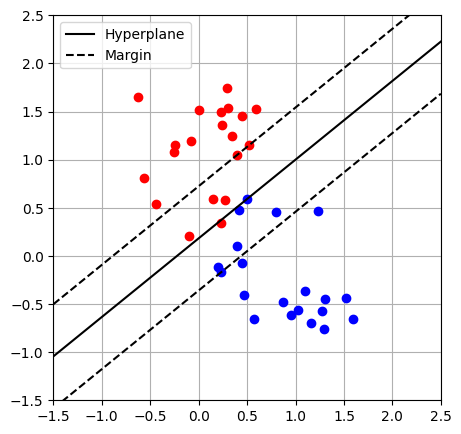

In [26]:
# call your svm_demo function here
svm_demo(20, [0, 1], [1, 0], 0.8)

# Submitting your project

**Make sure you have done all of the following things.**

0. Included **all** group members' student numbers at the top of this notebook.
1. Read through every part of the project to check you have answered all of it.
2. Carefully read and followed all of the [MATH0011 project instructions](https://www.ucl.ac.uk/~ucahmto/0011/project-instructions.html).
3. Checked that all of your code works correctly.

If you have, you're ready to submit.  **One** of the group members should download the completed notebook (in CoCalc, click the File menu next to the green Save button, then click Download) and submit it on the MATH0011 Moodle.  Please submit **one .ipynb file per group.**

------------------------------------ A NEW BEGINNING! ------------------------------------\
Here we start our project on extending the above code's functionality.\
We begin with the aim to implement an SVM from scratch, focusing on understanding and implementing the kernel trick from scratch, particularly the polynomial kernel.\
The goal is to handle non-linearly separable data by transforming it into a higher-dimensional space where it becomes linearly separable.\
This aim is our starting point, at least.

Here is a proposed step-by-step appraoch to achieving the above goal, similar in structure to how the linear SVM project was approached.\

1. Kernel Function Implementation
    - Implement a basic linear kernel function
    - Implement a polynomial kernel function
    - (Optional) Implement a Gaussian (RBF) kernel function

2. Kernel Matrix Computation
    -  Create a function to compute the kernel matrix for a given dataset and kernel function

3. Dual Form SVM Formulation
    - Implement the dual form of the SVM optimisation problem
    - Modify the loss function to use the kernel matrix

4. Quadratic Programming Solver
    - Implement from scratch a quadratic programming solver to find the optimal Lagrange multipliers e.g. a simple solver like SMO or gradient ascent for the dual problem

5. Support Vector Identification
    - Implement a method to identify support vectors based on the solved Lagrange multipliers

6. Decision Function
    - Implement the SVM decision function using the kernel trick

7. Non-linear Data Generation
    - Create functions to generate non-linearly separable datasets for testing

8. Training and Prediction
    - Implement functions for training the SVM and making predictions on new data

9. Visualisation
    - Extend the current visualisation code to plot decision boundaries for non-linear SVMs

10. Hyperparameter Tuning
    - Implement methods for tuning kernel parameters (e.g., degree for polynomial kernel)

11. Performance Evaluation
    - Implement metrics to evaluate the SVM's performance on various datasets

12. Comparison with Linear SVM
    - Create experiments to compare the performance of kernelised SVM with linear SVM